**words, we're going to deploy our FoodVision Mini model to the internet as a usable app!**



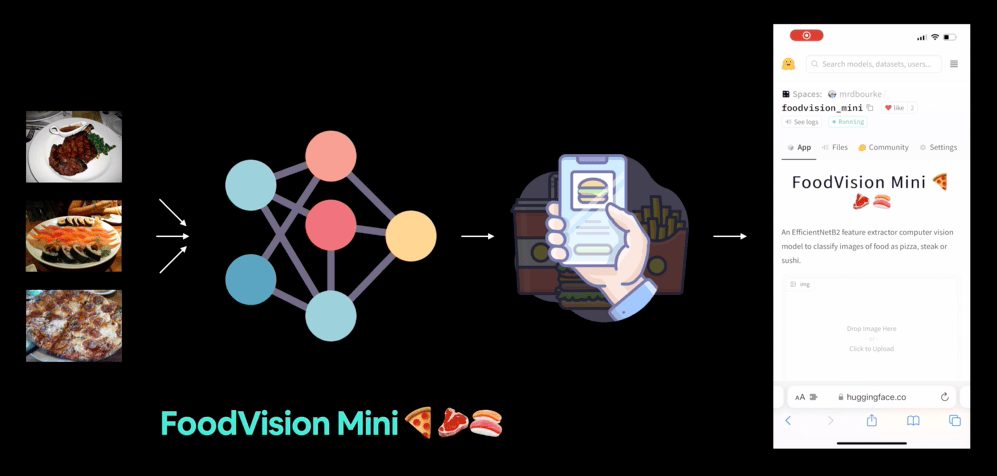

# **What is machine learning model deployment?**
Machine learning model deployment is the process of making your machine learning model accessible to someone or something else.

Someone else being a person who can interact with your model in some way.

For example, someone taking a photo on their smartphone of food and then having our FoodVision Mini model classify it into pizza, steak or sushi.

Something else might be another program, app or even another model that interacts with your machine learning model(s).

For example, a banking database might rely on a machine learning model making predictions as to whether a transaction is fraudulent or not before transferring funds.

Or an operating system may lower its resource consumption based on a machine learning model making predictions on how much power someone generally uses at specific times of day.

These use cases can be mixed and matched as well.

For example, a Tesla car's computer vision system will interact with the car's route planning program (something else) and then the route planning program will get inputs and feedback from the driver (someone else).



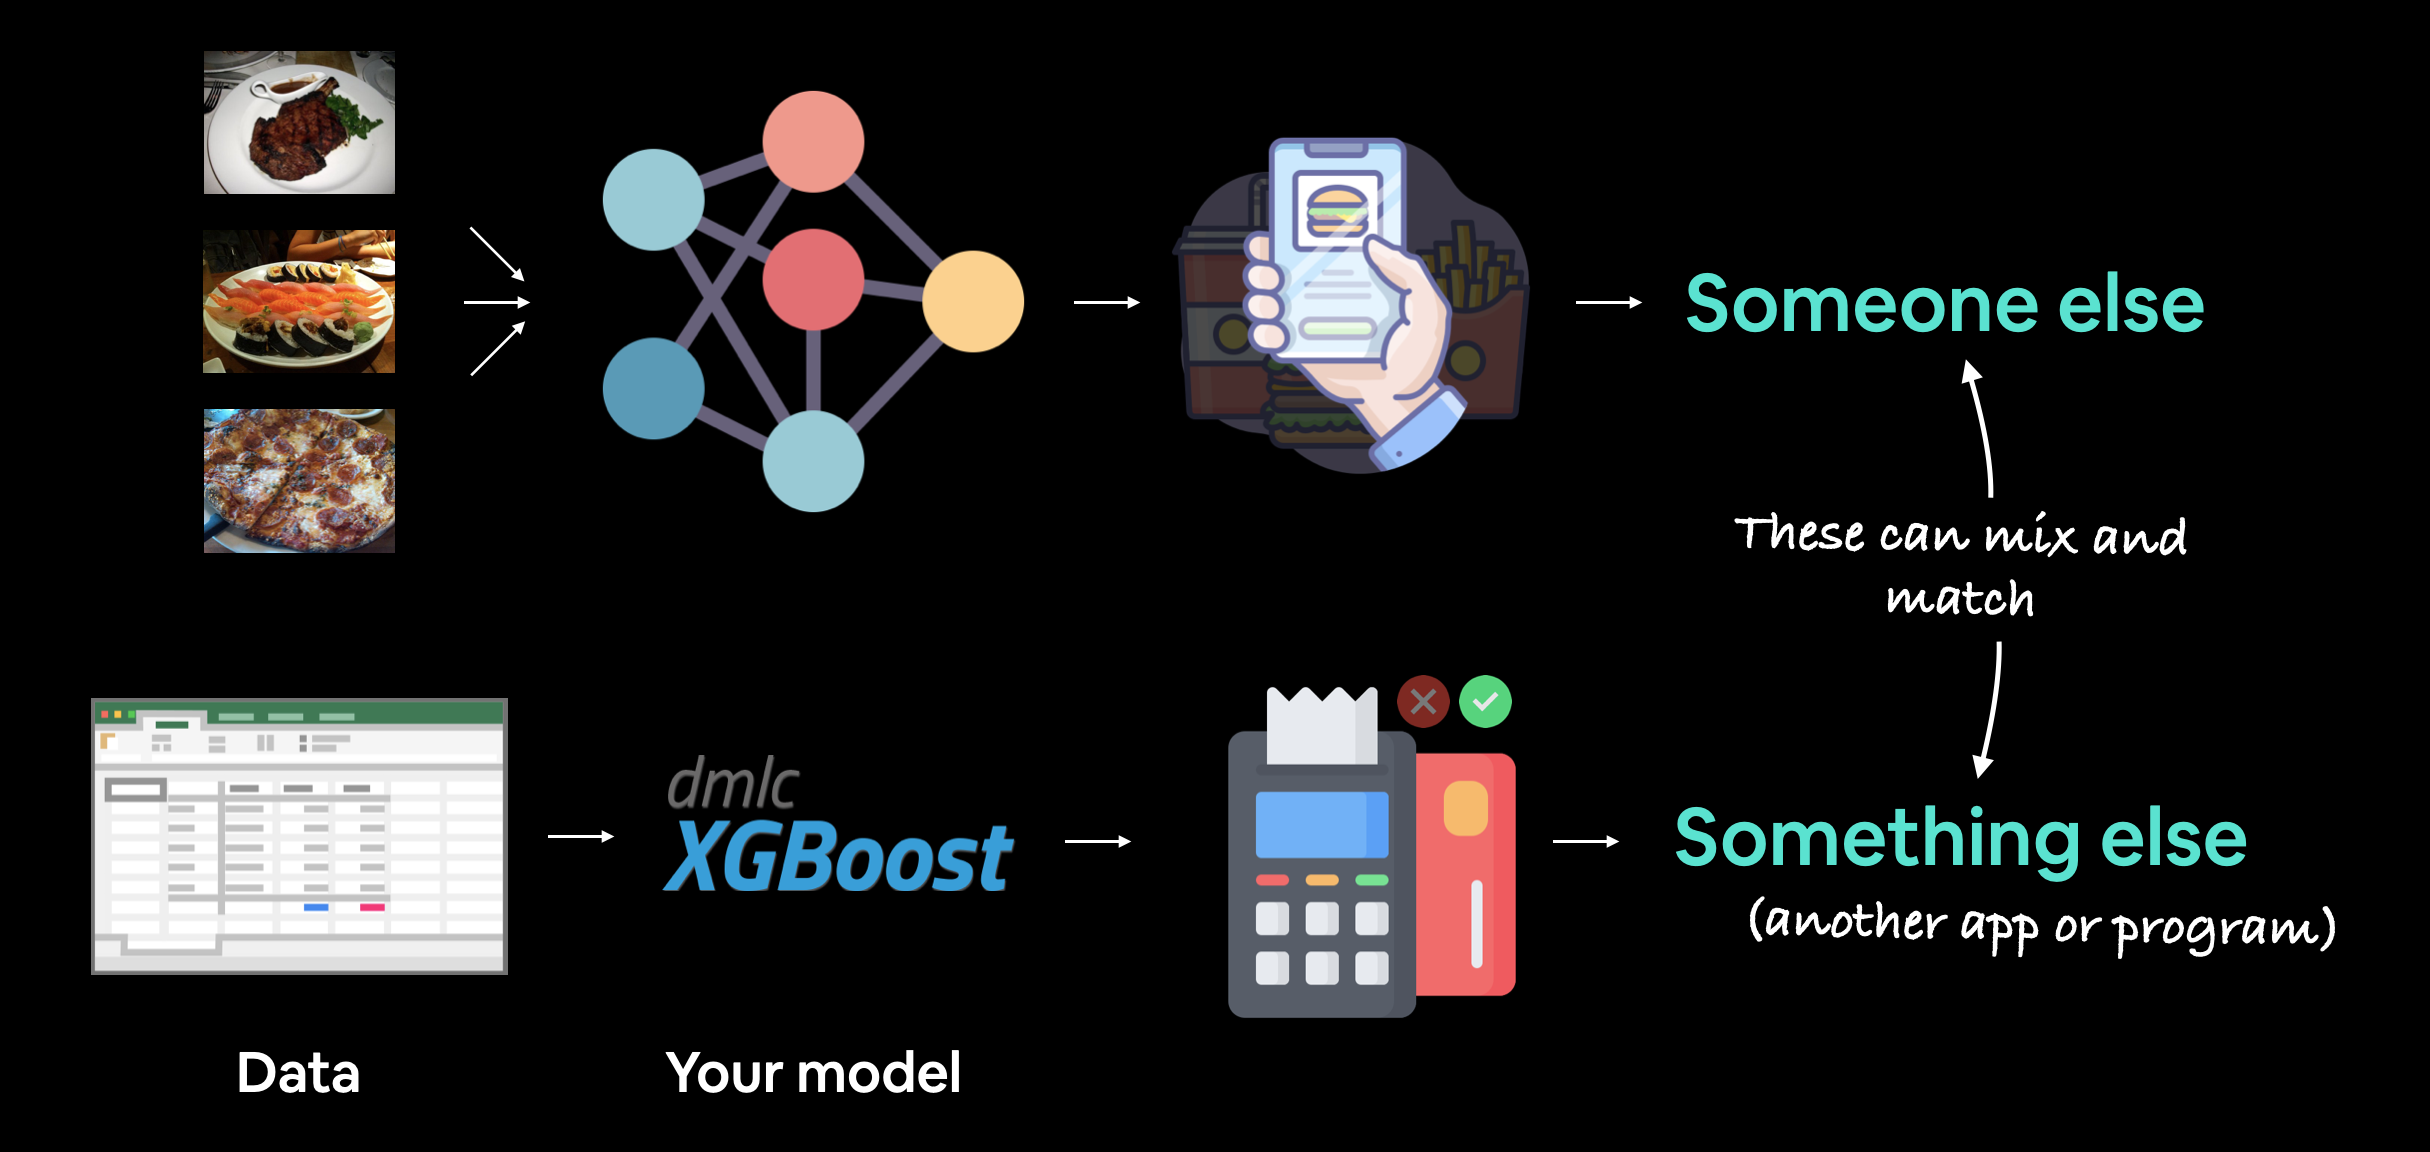

Machine learning model deployment involves making your model available to someone or something else. For example, someone might use your model as part of a food recognition app (such as FoodVision Mini or **Nutrify**). And something else might be another model or program using your model such as a banking system using a machine learning model to detect if a transaction is fraud or not.

##**Why deploy a machine learning model?**
One of the most important philosophical questions in machine learning is:



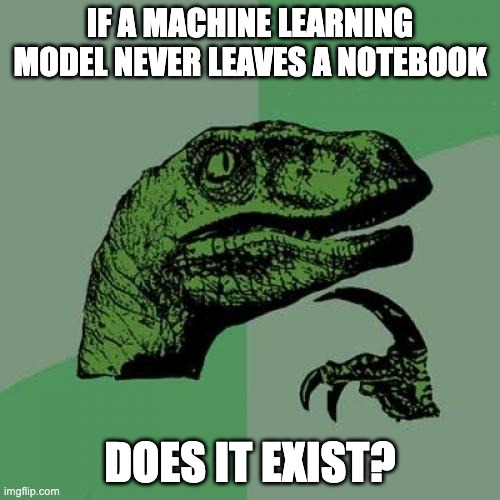

Deploying a model is as important as training one.

Because although you can get a pretty good idea of how your model's going to function by evaluting it on a well crafted test set or visualizing its results, you never really know how it's going to perform until you release it to the wild.

Having people who've never used your model interact with it will often reveal edge cases you never thought of during training.

For example, what happens if someone was to upload a photo that wasn't of food to our FoodVision Mini model?

One solution would be to create another model that first classifies images as "food" or "not food" and passing the target image through that model first (this is what Nutrify does).

Then if the image is of "food" it goes to our FoodVision Mini model and gets classified into pizza, steak or sushi.

And if it's "not food", a message is displayed.

Thus this highlights the importance of model deployment: it helps you figure out errors in your model that aren't obvious during training/testing.

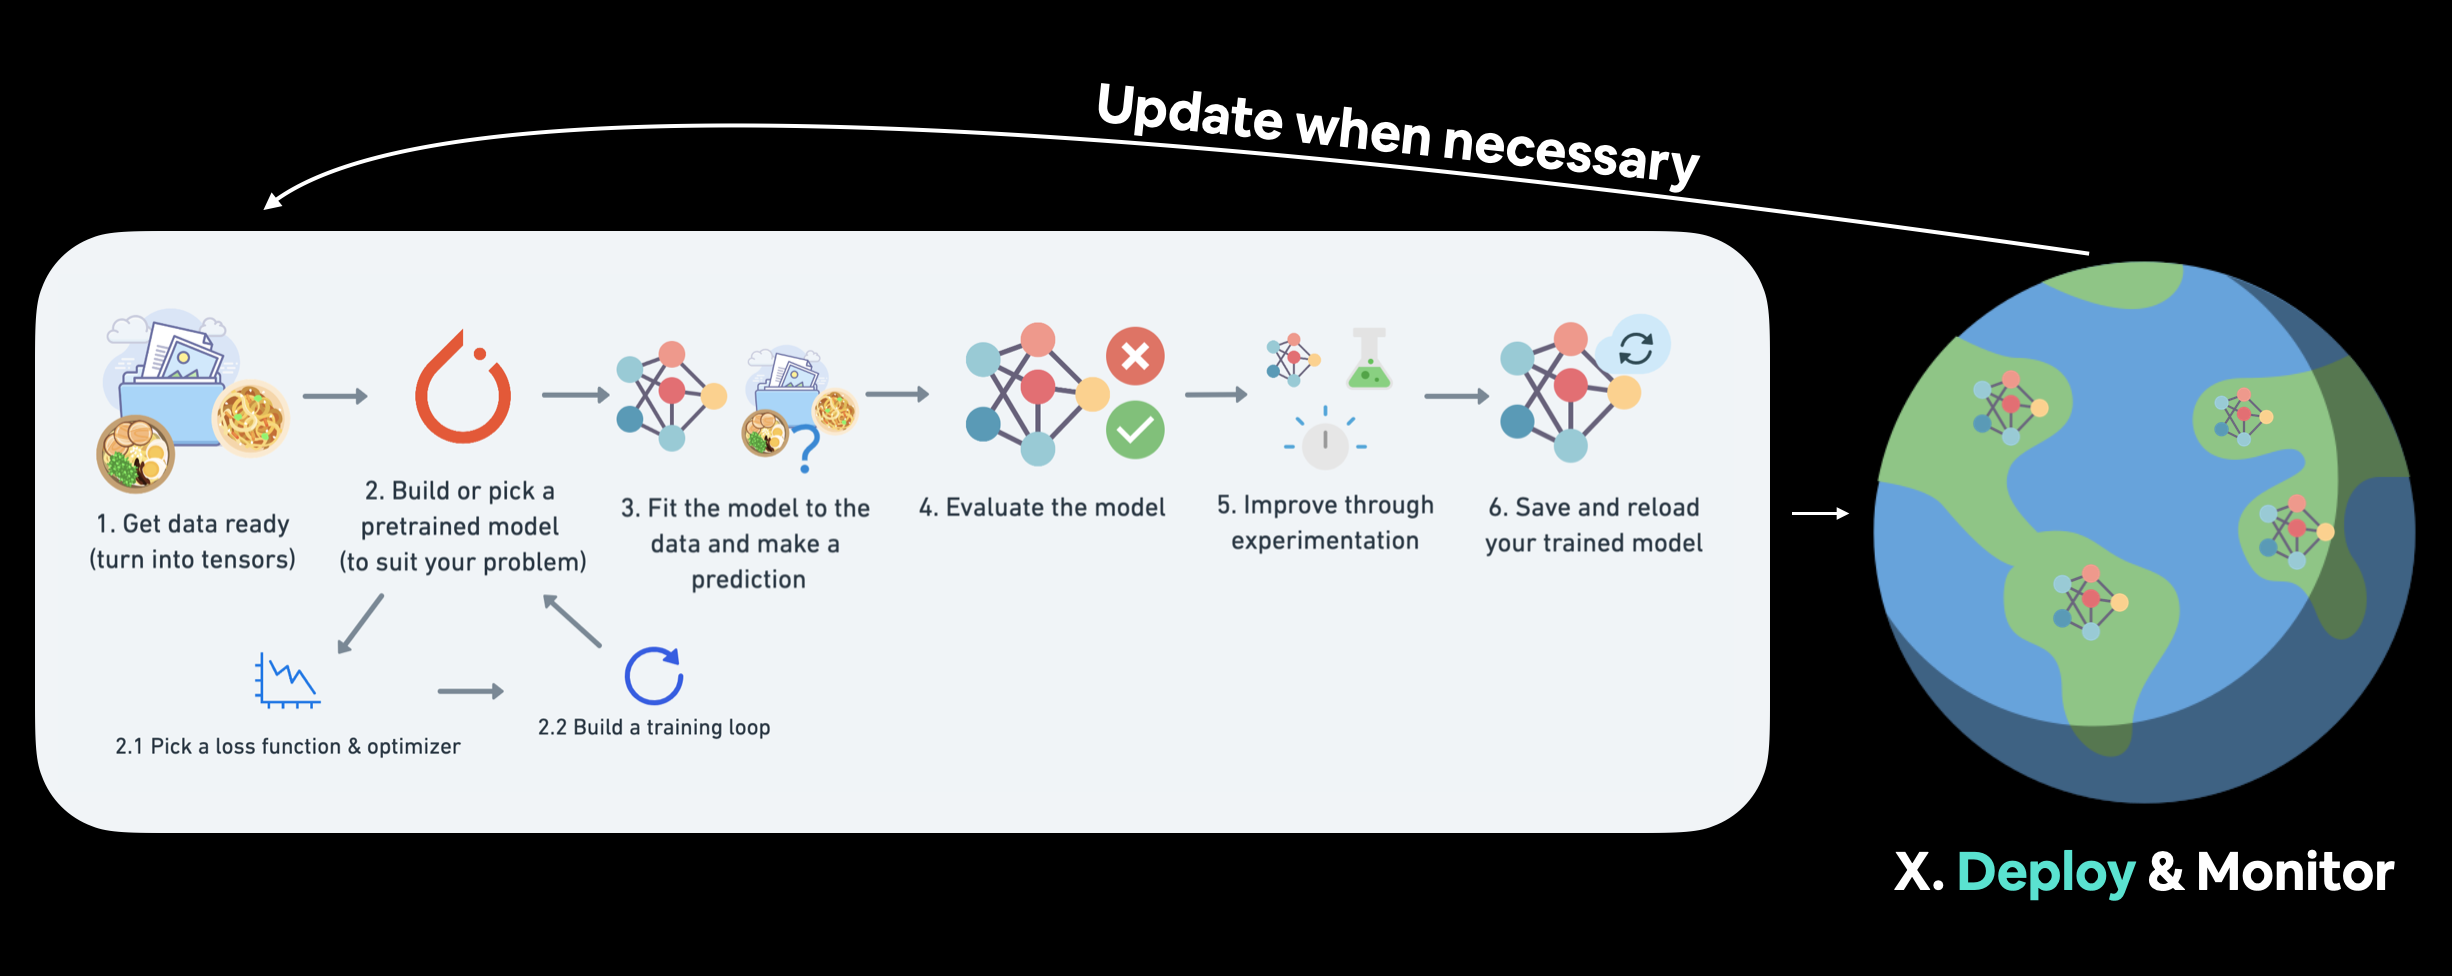

#**Deployment done by two types**

* **On-device (edge/in the browser)**
* **On cloud**

If we're deploying FoodVision Mini as an app, we want it to perform well and fast.

So which model would we prefer?

* A model on-device that performs at 95% accuracy with an inference time (latency) of one second per prediction.
* A model on the cloud that performs at 98% accuracy with an inference time of 10 seconds per per prediction (bigger, better model but takes longer to compute).

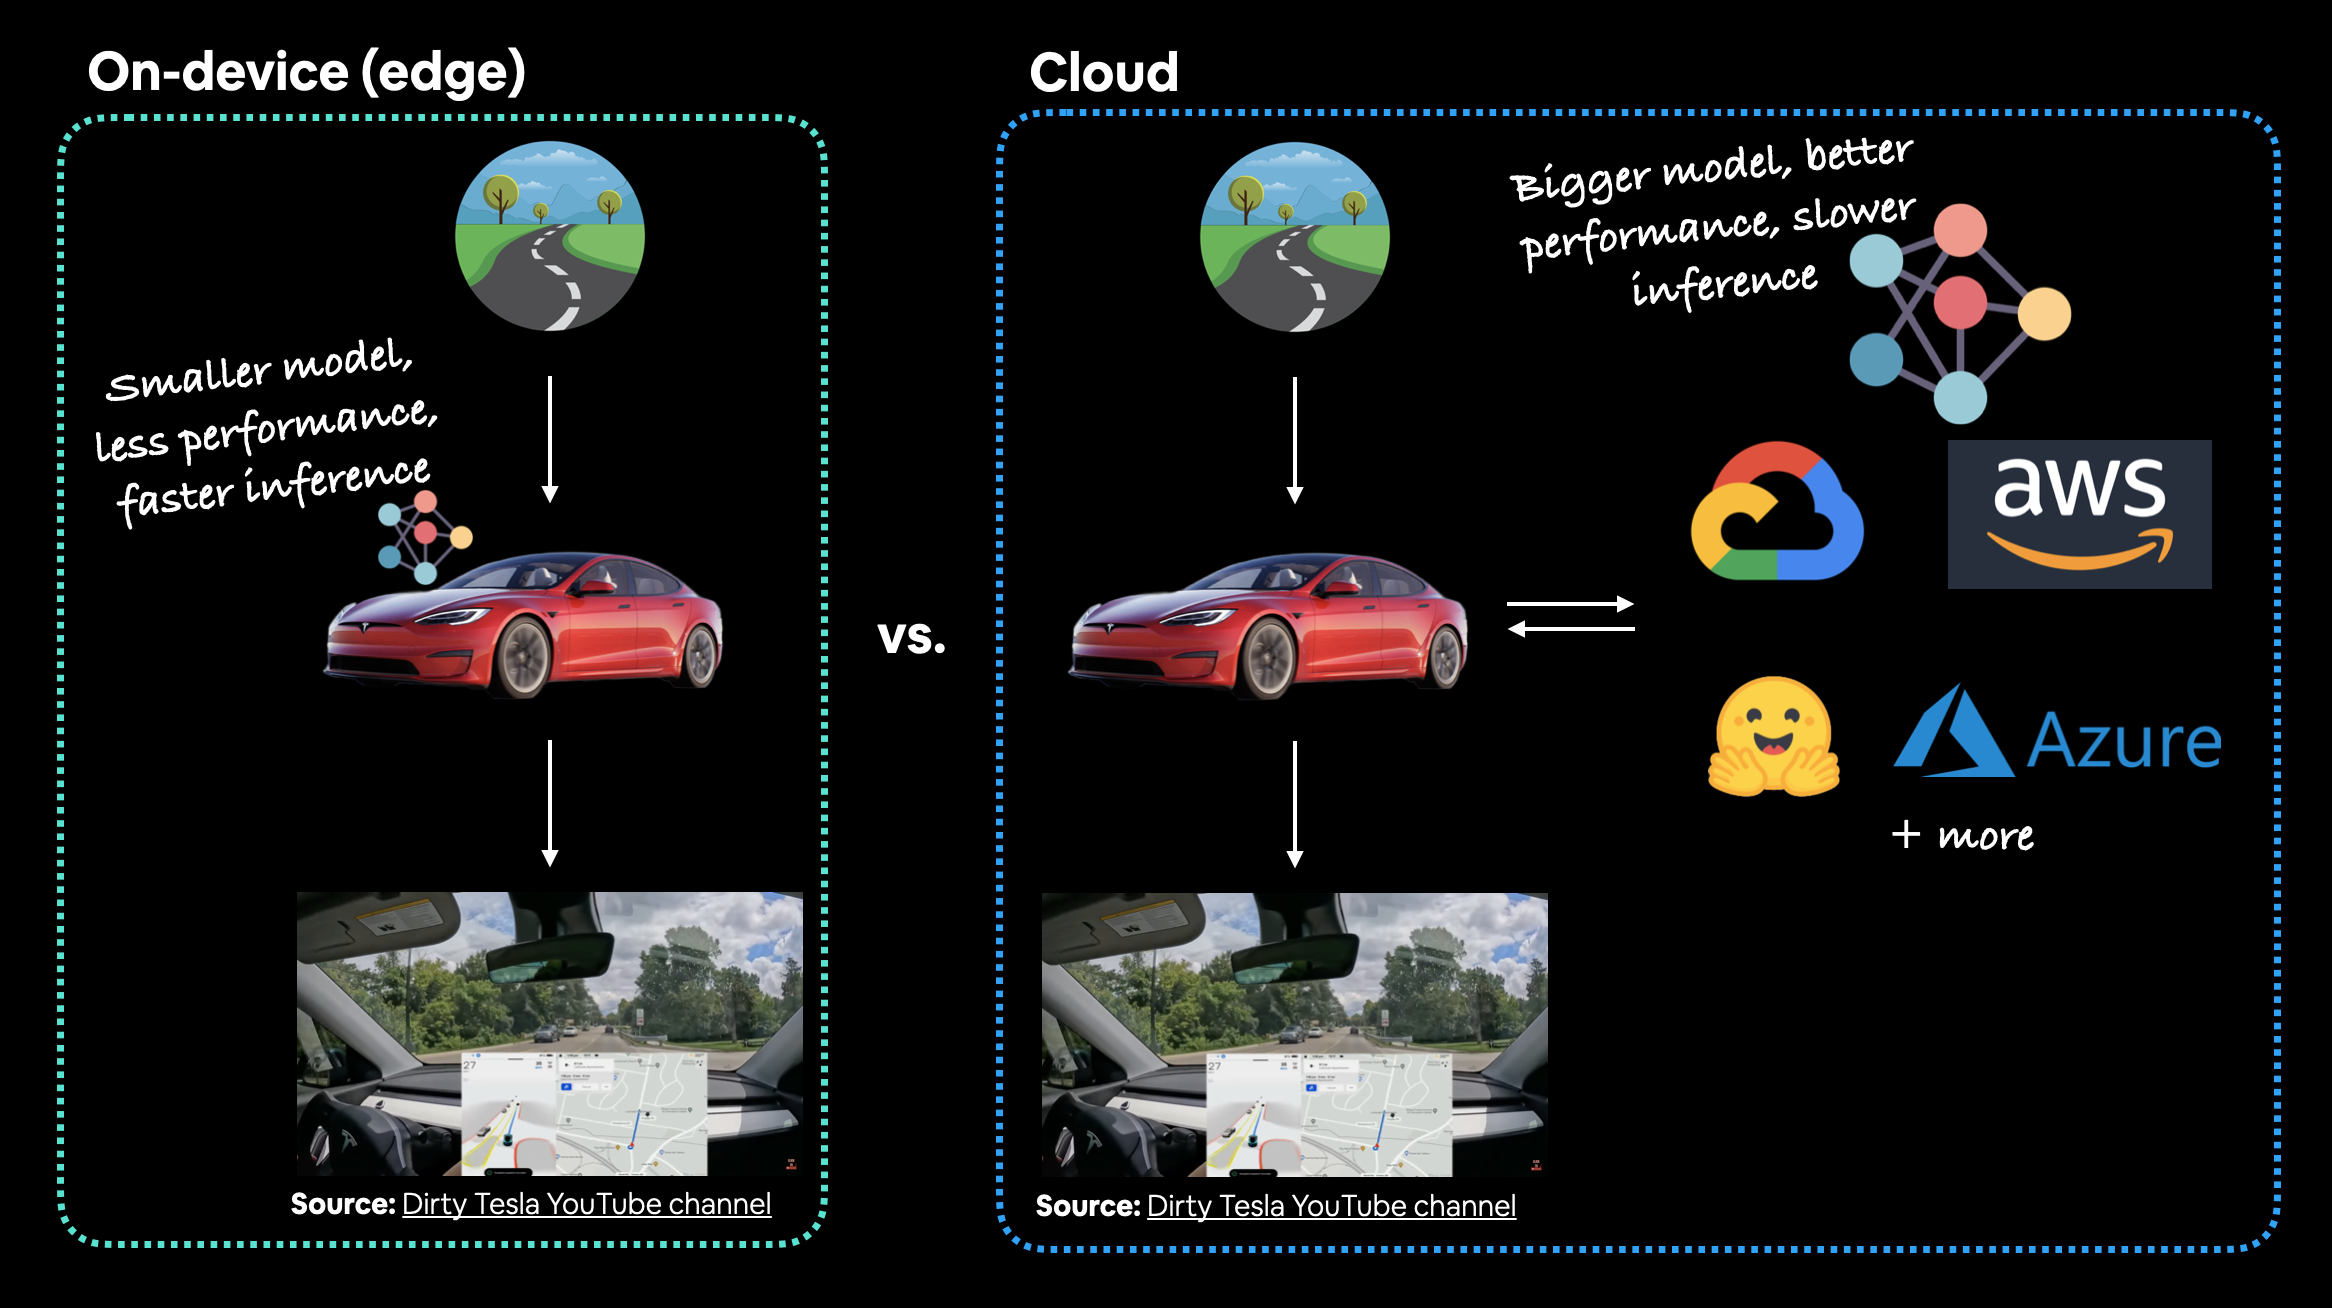

In the case of a Tesla car's computer vision system, which would be better? A smaller model that performs well on device (model is on the car) or a larger model that performs better that's on the cloud? In this case, you'd much prefer the model being on the car. The extra network time it would take for data to go from the car to the cloud and then back to the car just wouldn't be worth it (or potentially even possible with poor signal areas).

# **Goal**

Our goal is to deploy our FoodVision Model via a demo Gradio app with the following metrics:

* Performance: 95%+ accuracy.
* Speed: real-time inference of 30FPS+ (each prediction has a latency of lower than ~0.03s).
We'll start by running an experiment to compare our best two models so far: EffNetB2 and ViT feature extractors.

Then we'll deploy the one which performs closest to our goal metrics.

Finally, we'll finish with a (BIG) surprise bonus.

#**0. Getting setup**

**Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via Runtime -> Change runtime type -> Hardware accelerator -> GPU.

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/gurpreetsingh1111/Food_Vision_App/tree/main/going_modular
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3820, done.
remote: Counting objects: 100% (463/463), done.
remote: Compressing objects: 100% (260/260), done.
remote: Total 3820 (delta 243), reused 400 (delta 196), pack-reused 3357
Receiving objects: 100% (3820/3820), 650.70 MiB | 30.35 MiB/s, done.
Resolving deltas: 100% (2199/2199), done.
Updating files: 100% (248/248), done.


Finally, we'll setup device-agnostic code to make sure our models run on the GPU.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#**1. Getting data**

The EffNetB2 model was trained on 20% of the pizza, steak and sushi data from Food101 where as the ViT model was trained on 10%.

Since our goal is to deploy the best model for our FoodVision Mini problem, let's start by downloading the 20% pizza, steak and sushi dataset and train an EffNetB2 feature extractor and ViT feature extractor on it and then compare the two models.

In [6]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/gurpreetsingh1111/Food_Vision_App/tree/main/going_modular",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

Now we've got a dataset, let's creat training and test paths.

In [ ]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

#**2. FoodVision Mini model deployment experiment outline**

The ideal deployed model FoodVision Mini performs well and fast.

We'd like our model to perform as close to real-time as possible.

Real-time in this case being ~30FPS (frames per second) because that's about how fast the human eye can see (there is debate on this but let's just use ~30FPS as our benchmark).

And for classifying three different classes (pizza, steak and sushi), we'd like a model that performs at 95%+ accuracy.

Of course, higher accuracy would be nice but this might sacrifice speed.

So our goals are:

* **Performance** - A model that performs at 95%+ accuracy.
* **Speed** - A model that can classify an image at ~30FPS (0.03 seconds inference time per image, also known as latency).


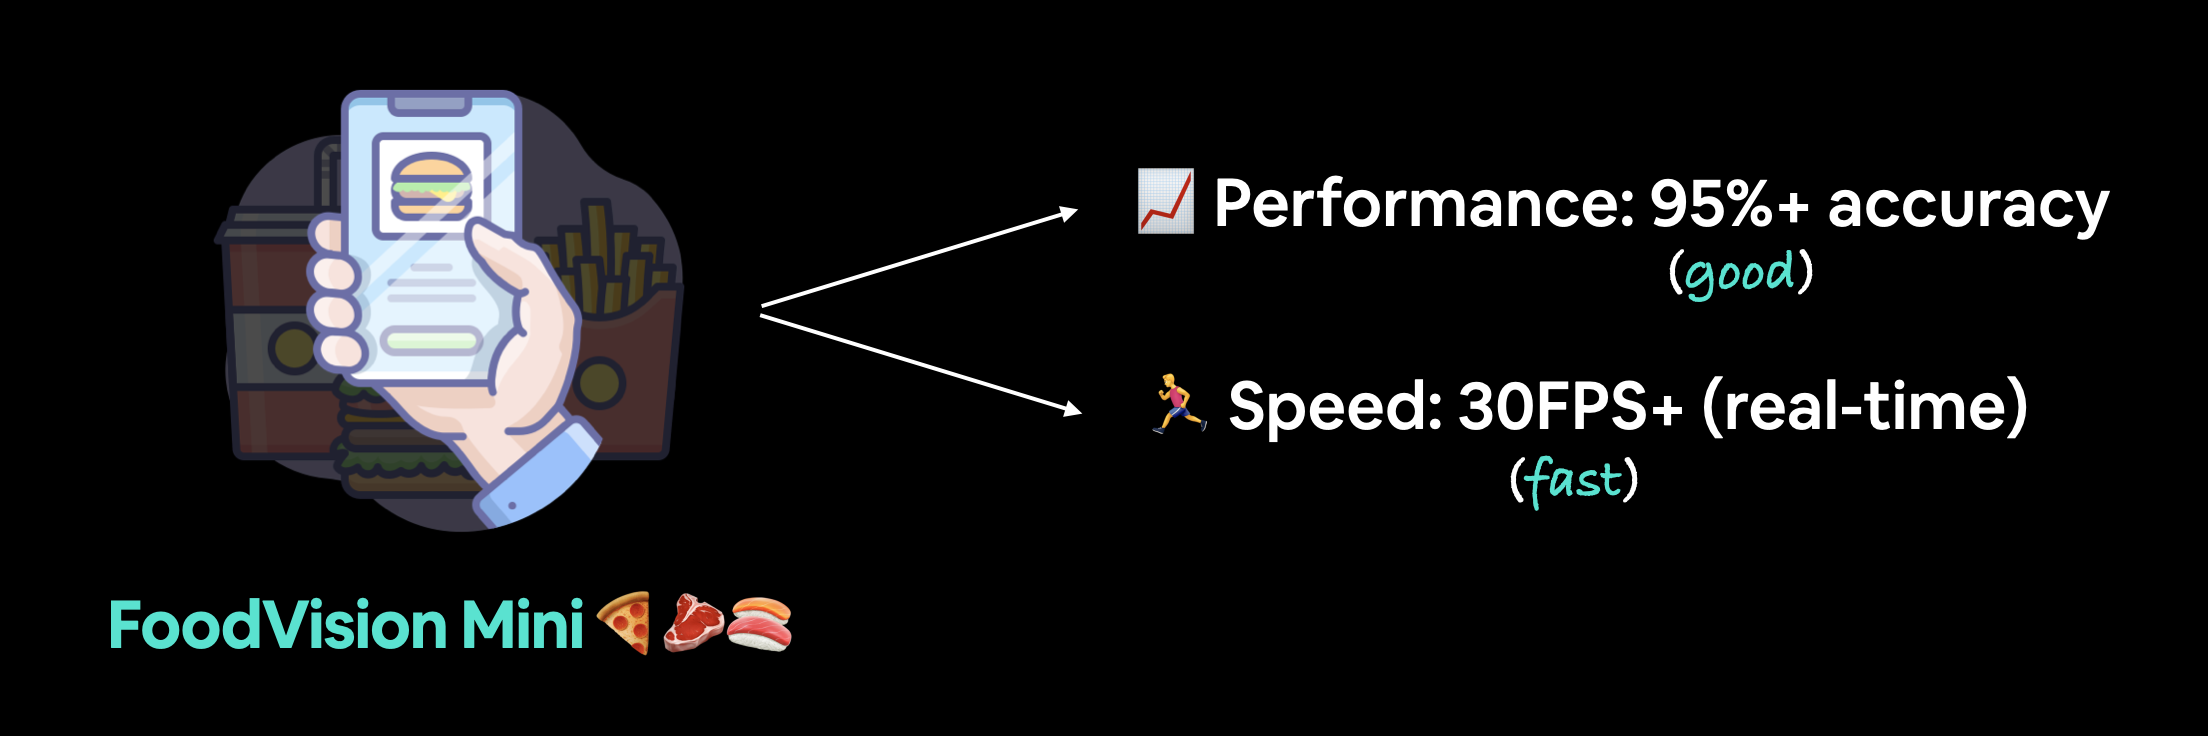

We'll put an emphasis on speed, meaning, we'd prefer a model performing at 90%+ accuracy at ~30FPS than a model performing 95%+ accuracy at 10FPS.

To try and achieve these results, let's bring in our best performing models from the previous sections:

* **EffNetB2 feature extractor (EffNetB2 for short)** - originally created in 07. PyTorch Experiment Tracking section 7.5 using torchvision.models.efficientnet_b2() with adjusted classifier layers.
* **ViT-B/16 feature extractor (ViT for short)** - originally created in 08. PyTorch Paper Replicating section 10 using torchvision.models.vit_b_16() with adjusted head layers.

**Note**: ViT-B/16 stands for "Vision Transformer Base, patch size 16".


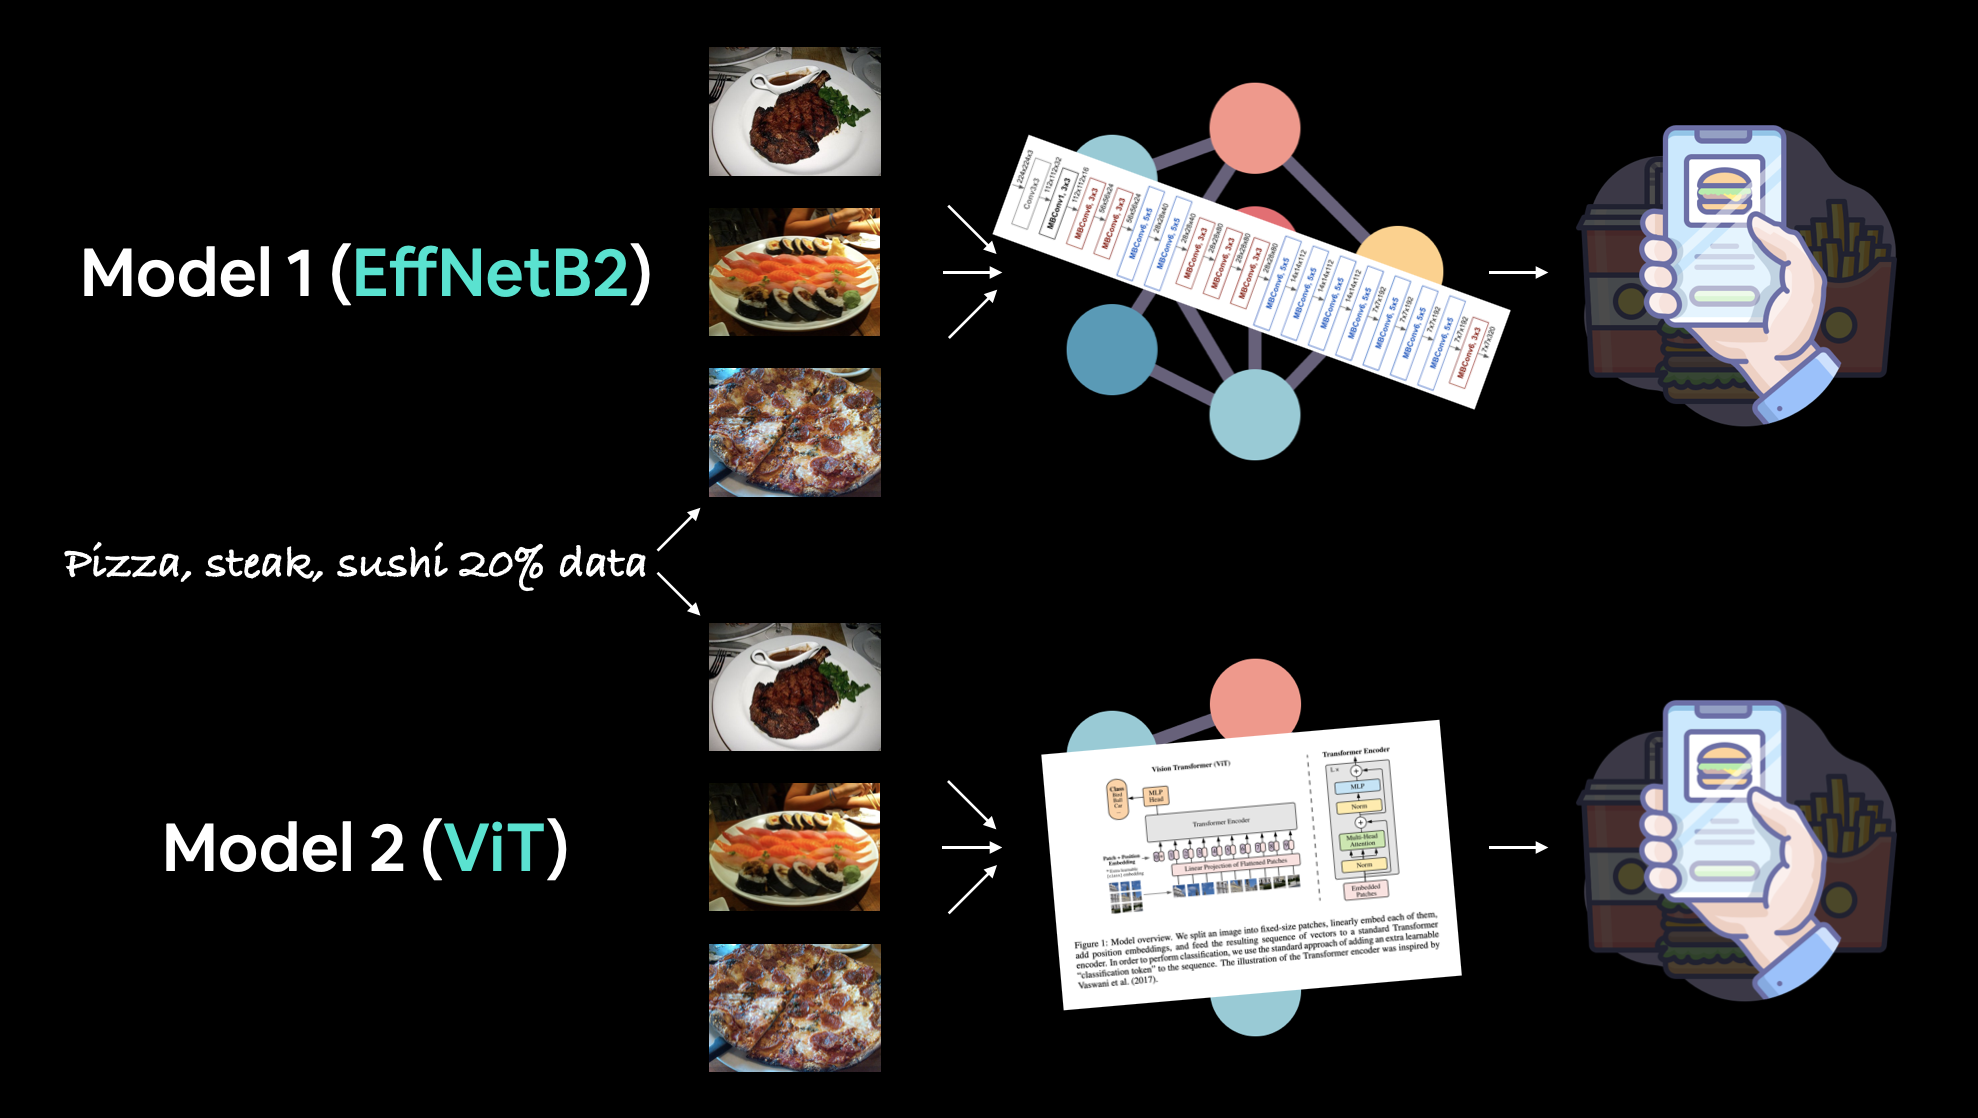

# **3. Creating an EffNetB2 feature extractor**

Let's now recreate it here so we can compare its results to a ViT feature extractor trained on the same data.

In [ ]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in effnetb2.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 85.3MB/s]


Now to change the **classifier** head, let's first inspect it using the classifier attribute of our model.

In [ ]:
# Check out EffNetB2 classifier head
effnetb2.classifier


Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

To change the classifier head to suit our own problem, let's replace the **out_features** variable with the same number of classes we have(in our case, **out_features=3**, one for pizza, steak, sushi).

In [ ]:
# 5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same 
              out_features=3)) # change out_features to suit our number of classes

## **3.1 Creating a function to make an EffNetB2 feature extractor**

our EffNetB2 feature extractor is ready to go, however, since there's quite a few steps involved here, how about we turn the code above into a function we can re-use later?

In [ ]:
def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

No errors, nice, now to really try it out, let's get a summary with **torchinfo.summary()**.

In [ ]:
from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output) 
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

##**3.2 Creating DataLoaders for EffNetB2**

 EffNetB2 feature extractor is ready, time to create some DataLoaders.

We can do this by using the **data_setup.create_dataloaders()** function.

We'll use a **batch_size** of 32 and transform our images using the **effnetb2_transforms** so they're in the same format that our effnetb2 model was trained on.

In [ ]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

    

# **3.3 Training EffNetB2 feature extractor**

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9848 | train_acc: 0.5667 | test_loss: 0.7388 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7138 | train_acc: 0.8375 | test_loss: 0.5851 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5871 | train_acc: 0.8938 | test_loss: 0.4897 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4480 | train_acc: 0.9104 | test_loss: 0.4342 | test_acc: 0.9318
Epoch: 5 | train_loss: 0.4264 | train_acc: 0.9125 | test_loss: 0.3899 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4377 | train_acc: 0.8896 | test_loss: 0.3513 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4238 | train_acc: 0.8750 | test_loss: 0.3264 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3881 | train_acc: 0.8979 | test_loss: 0.3458 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3773 | train_acc: 0.8792 | test_loss: 0.3125 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3739 | train_acc: 0.8688 | test_loss: 0.2809 | test_acc: 0.9688


# **3.4 Inspecting EffNetB2 loss curves**

**Note:** Loss curves are one of the best ways to visualize how your model's performing.

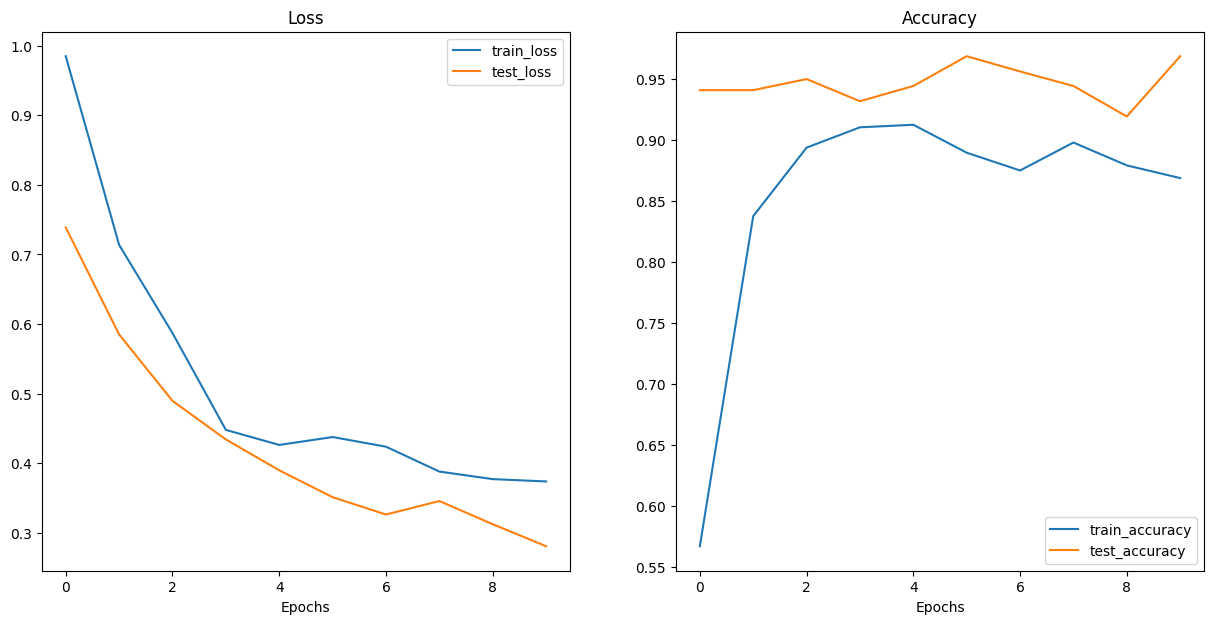

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

Those are some nice looking loss curves.

It looks like our model is performing quite well and perhaps would benefit from a little longer training and potentially some **data augmentation** (to help prevent potential overfitting occurring from longer training).

#**3.5 Saving EffNetB2 feature extractor**

In [ ]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


# **3.6 Checking the size of EffNetB2 feature extractor**

Since one of our criteria for deploying a model to power FoodVision Mini is **speed (~30FPS or better)**, let's check the size of our model.

Why check the size?

Well, while not always the case, the size of a model can influence its inference speed.

As in, if a model has more parameters, it generally performs more operations and each one of these operations requires some computing power.

And because we'd like our model to work on devices with limited computing power (e.g. on a mobile device or in a web browser), generally, the smaller the size the better (as long as it still performs well in terms of accuracy).

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("https://github.com/gurpreetsingh1111/Food_Vision_App/blob/main/going_modular/going_modular/models/05_going_modular_cell_mode_tinyvgg_model.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


# **3.7 Collecting EffNetB2 feature extractor stats**

We've got a few statistics about our EffNetB2 feature extractor model such as test loss, test accuracy and model size, how about we collect them all in a dictionary so we can compare them to the upcoming ViT feature extractor.

We can do so by counting the number of elements (or patterns/weights) in **effnetb2.parameters().** We'll access the number of elements in each parameter using the **torch.numel()** (short for "number of elements") method.

In [ ]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

Now let's put everything in a dictionary so we can make comparisons later on.

In [ ]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.2808644324541092,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

Looks like our EffNetB2 model is performing at over 95% accuracy!

Criteria number 1: perform at 95%+ accuracy, tick!

# **4. Creating a ViT feature extractor....**

Time to continue with our FoodVision Mini modelling experiments.

This time we're going to create a ViT feature extractor.

And we'll do it in much the same way as the EffNetB2 feature extractor except this time with **torchvision.models.vit_b_16()** instead of **torchvision.models.efficientnet_b2().**

In [ ]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes:int=3, 
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model. 
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes
    
    return model, transforms

ViT feature extraction model creation function ready!

In [ ]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 86.5MB/s]


Now let's get a nice-looking summary of our ViT model using **torchinfo.summary().**

In [ ]:
from torchinfo import summary

# # Print ViT feature extractor model summary (uncomment for full output)
summary(vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

Just like our EffNetB2 feature extractor model, our ViT model's base layers are frozen and the output layer is customized to our needs!

Do you notice the big difference though?

Our ViT model has far more parameters than our EffNetB2 model. Perhaps this will come into play when we compare are our models across speed and performance later on.

##4.1 Create DataLoaders for ViT

In [ ]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

##4.2 Training ViT feature extractor

Let's train our ViT feature extractor model for 10 epochs using our **engine.train()** function with **torch.optim.Adam()** and a learning rate of 1e-3 as our optimizer and **torch.nn.CrossEntropyLoss()** as our loss function.

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


##4.3 Inspecting ViT loss curves

 ViT model trained, let's get visual and see some loss curves

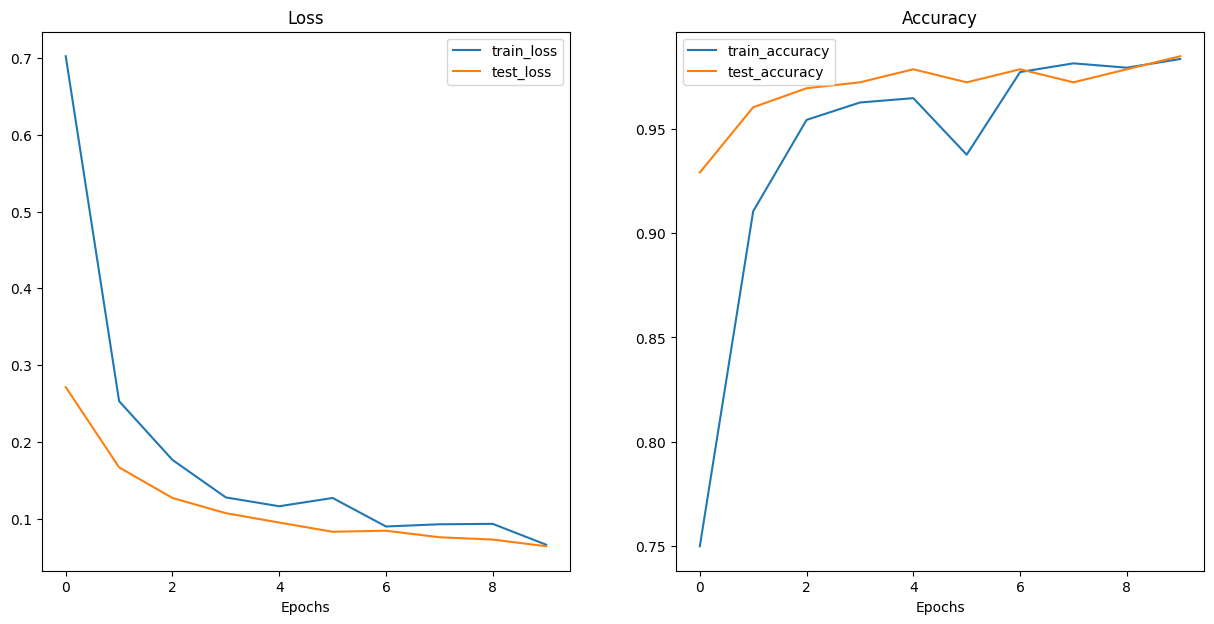

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

Those are some nice looking loss curves. Just like our EffNetB2 feature extractor model, it looks our ViT model might benefit from a little longer training time and perhaps some **data augmentation** (to help **prevent overfitting**).

##4.4 Saving ViT feature extracto

Our ViT model is performing outstanding!

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


## 4.5 Checking the size of ViT feature extractor
And since we want to compare our EffNetB2 model to our ViT model across a number of characteristics, let's find out its size.

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("https://github.com/gurpreetsingh1111/Food_Vision_App/blob/main/going_modular/going_modular/models/05_going_modular_script_mode_tinyvgg_model.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


##4.6 Collecting ViT feature extractor stats

In [ ]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

**Note:** A larger number of parameters (or weights/patterns) generally means a model has a higher capacity to learn, whether it actually uses this extra capacity is another story. In light of this, our EffNetB2 model has 7,705,221 parameters where as our ViT model has 85,800,963 (11.1x more) so we could assume that our ViT model has more of a capacity to learn, if given more data (more opportunities to learn). However, this larger capacity to learn ofen comes with an increased model filesize and a longer time to perform inference.

In [ ]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06418210905976593,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

# 5.Making predictions with our trained models and timing them

We've got a couple of trained models, both performing pretty well.

Now how about we test them out doing what we'd like them to do?

As in, let's see how they go making predictions (performing inference).

We know both of our models are performing at over 95% accuracy on the test dataset, but how fast are they?

Ideally, if we're deploying our FoodVision Mini model to a mobile device so people can take photos of their food and identify it, we'd like the predictions to happen at real-time (~30 frames per second).

That's why our second criteria is: a fast model.

To find out how long each of our models take to performance inference, let's create a function called pred_and_store() to iterate over each of the test dataset images one by one and perform a prediction.

We'll time each of the predictions as well as store the results in a common prediction format: a list of dictionaries (where each element in the list is a single prediction and each sinlge prediction is a dictionary).

In [ ]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3497151.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/788315.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3174637.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/380739.jpg')]

##5.1 Creating a function to make predictions across the test dataset

In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms, 
                   class_names: List[str], 
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    # 2. Create an empty list to store prediction dictionaires
    pred_list = []
    
    # 3. Loop through target paths
    for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer
        start_time = timer()
        
        # 7. Open image path
        img = Image.open(path)
        
        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device) 
        
        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()
        
        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample 
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # 15. Return list of prediction dictionaries
    return pred_list

##5.2 Making and timing predictions with EffNetB2

In [ ]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

Let's inspect the first couple and see what they look like.

In [ ]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.5207,
  'pred_class': 'sushi',
  'time_for_pred': 0.2706,
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3497151.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.986,
  'pred_class': 'pizza',
  'time_for_pred': 0.1148,
  'correct': True}]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

image_path class_name  pred_prob  \
0  data/pizza_steak_sushi_20_percent/test/pizza/1...      pizza     0.5207   
1  data/pizza_steak_sushi_20_percent/test/pizza/3...      pizza     0.9860   
2  data/pizza_steak_sushi_20_percent/test/pizza/7...      pizza     0.7439   
3  data/pizza_steak_sushi_20_percent/test/pizza/3...      pizza     0.9098   
4  data/pizza_steak_sushi_20_percent/test/pizza/3...      pizza     0.9439   

  pred_class  time_for_pred  correct  
0      sushi         0.2706    False  
1      pizza         0.1148     True  
2      pizza         0.1151     True  
3      pizza         0.1081     True  
4      pizza         0.1080     True

In [ ]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

True     145
False      5
Name: correct, dtype: int64

Five wrong predictions out of 150 total, not bad!

And how about the average prediction time?

In [ ]:
# Find the average time per prediction 
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1202 seconds


**Note:** Prediction times will be different across different hardware types (e.g. a local Intel i9 vs Google Colab CPU). The better and faster the hardware, generally, the faster the prediction. 

In [ ]:
# Add EffNetB2 average prediction time to stats dictionary 
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.2808644324541092,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1202}

## 5.3 Making and timing predictions with ViT

We've made predictions with our EffNetB2 model, now let's do the same for our ViT model.

In [ ]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

Now let's check out the first couple.

In [ ]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9963,
  'pred_class': 'pizza',
  'time_for_pred': 0.6022,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3497151.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9938,
  'pred_class': 'pizza',
  'time_for_pred': 0.4335,
  'correct': True}]

And just like before, since our ViT model's predictions are in the form of a list of dictionaries, we can easily turn them into a pandas DataFrame for further inspection.

In [ ]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

image_path class_name  pred_prob  \
0  data/pizza_steak_sushi_20_percent/test/pizza/1...      pizza     0.9963   
1  data/pizza_steak_sushi_20_percent/test/pizza/3...      pizza     0.9938   
2  data/pizza_steak_sushi_20_percent/test/pizza/7...      pizza     0.9980   
3  data/pizza_steak_sushi_20_percent/test/pizza/3...      pizza     0.9988   
4  data/pizza_steak_sushi_20_percent/test/pizza/3...      pizza     0.9976   

  pred_class  time_for_pred  correct  
0      pizza         0.6022     True  
1      pizza         0.4335     True  
2      pizza         0.4467     True  
3      pizza         0.4475     True  
4      pizza         0.4478     True

How many predictions did our ViT model get correct?

In [ ]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

Our ViT model did a little better than our EffNetB2 model in terms of correct predictions, only two samples wrong across the whole test dataset.

As an extension you might want to visualize the ViT model's wrong predictions and see if there's any reason why it might've got them wrong.

In [ ]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.4466 seconds


Well, that looks a little slower than our EffNetB2 model's average time per prediction but how does it look in terms of our second criteria: speed?

For now, let's add the value to our **vit_stats** dictionary so we can compare it to our EffNetB2 model's stats.

In [ ]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06418210905976593,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.4466}

# 6.Comparing model results, prediction times and size

In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

test_loss  test_acc  number_of_parameters  model_size (MB)  \
0   0.280864     96.88               7705221               29   
1   0.064182     98.47              85800963              327   

   time_per_pred_cpu     model  
0             0.1202  EffNetB2  
1             0.4466       ViT

It seems our models are quite close in terms of overall test accuracy but how do they look across the other fields?

One way to find out would be to divide the ViT model statistics by the EffNetB2 model statistics to find out the different ratios between the models.

In [ ]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

test_loss  test_acc  number_of_parameters  \
ViT to EffNetB2 ratios   0.228516  1.016412             11.135432   

                        model_size (MB)  time_per_pred_cpu  
ViT to EffNetB2 ratios        11.275862           3.715474

It seems our ViT model outperforms the EffNetB2 model across the performance metrics (test loss, where lower is better and test accuracy, where higher is better) but at the expense of having:

* 11x+ the number of parameters.
* 11x+ the model size.
* 2.5x+ the prediction time per image.

##6.1 Visualizing the speed vs. performance tradeof

We've seen that our ViT model outperforms our EffNetB2 model in terms of performance metrics such as test loss and test accuracy.

However, our EffNetB2 model makes performs predictions faster and has a much small model size.

**Note:** Performance or inference time is also often referred to as "latency".

FileNotFoundError: ignored

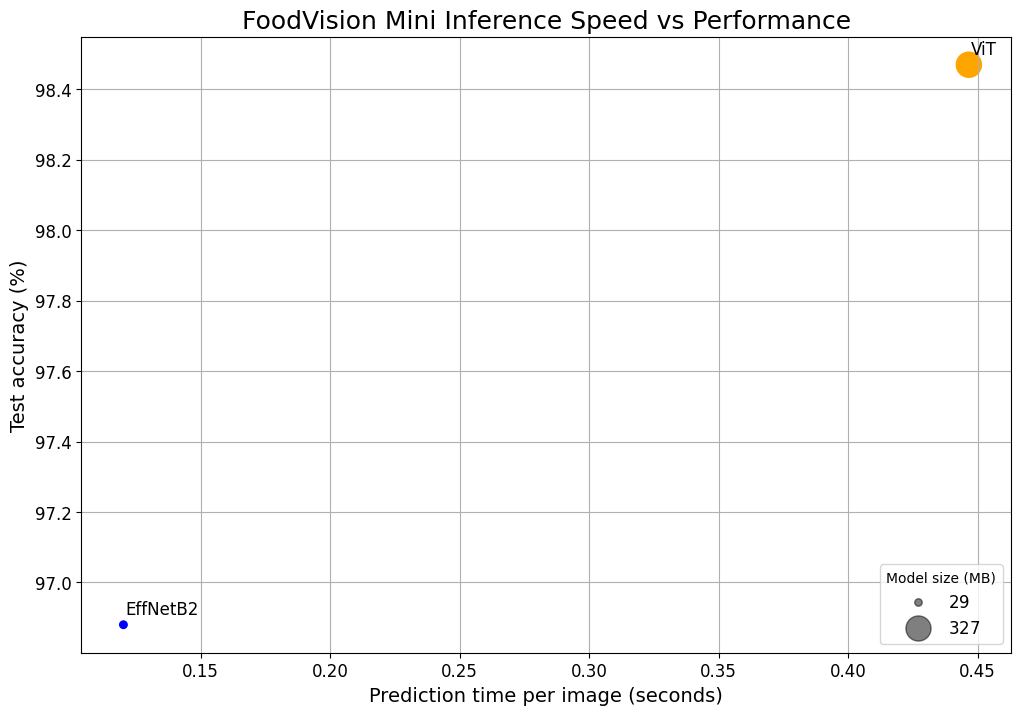

In [ ]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df, 
                     x="time_per_pred_cpu", 
                     y="test_acc", 
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270 
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

The plot really visualizes the speed vs. performance tradeoff, in other words, when you have a larger, better performing deep model (like our ViT model), it generally takes longer to perform inference (higher latency).

There are exceptions to the rule and new research is being published all the time to help make larger models perform faster.

And it can be tempting to just deploy the best performing model but it's also good to take into considersation where the model is going to be performing.

In our case, the differences between our model's performance levels (on the test loss and test accuracy) aren't too extreme.

# 7.Bringing FoodVision Mini to life by creating a Gradio demo

In [ ]:
# Import/install Gradio 
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.6 MB/s eta 0:

## 7.1 Gradio overview

Well that's what our machine learning model does.

* inputs -> ML model -> outputs
>In our case, for FoodVision Mini, our inputs are images of food, our ML model is EffNetB2 and our outputs are classes of food (pizza, steak or sushi).

* images of food -> EffNetB2 -> outputs
>Though the concepts of inputs and outputs can be bridged to almost any other kind of ML problem.

Gradio emulates this paradigm by creating an interface (**gradio.Interface()**) to from inputs to outputs.

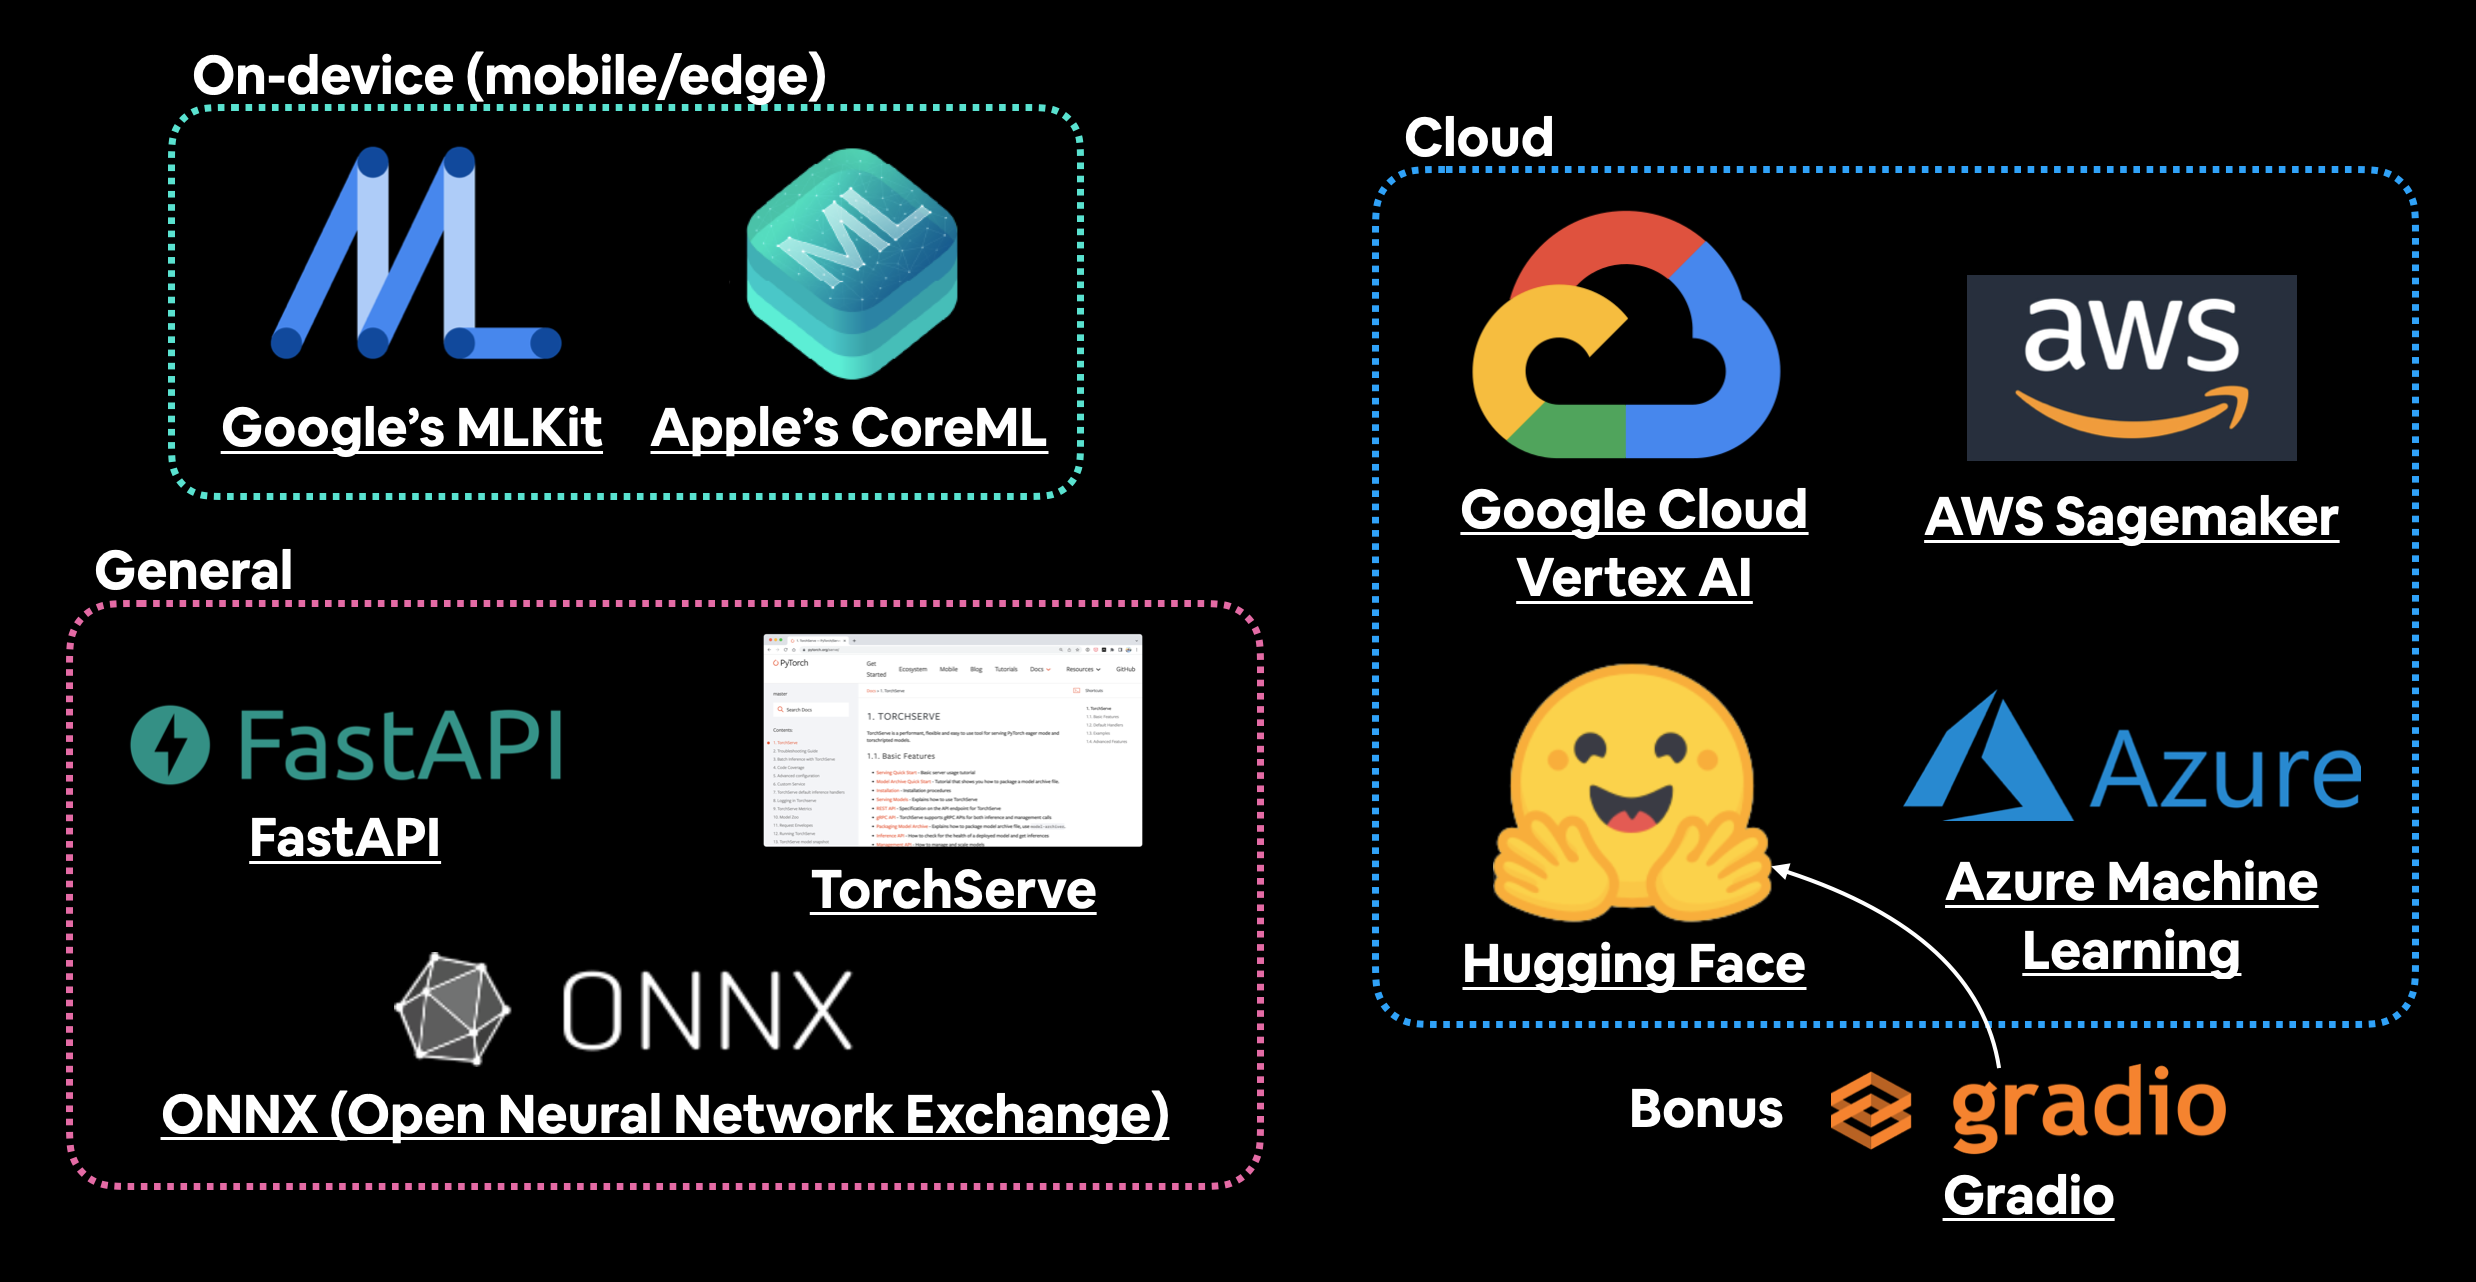

Gradio provides a very helpful Interface class to easily create an **inputs -> model/function -> outputs** workflow where the inputs and outputs could be almost anything you want. For example, you might input Tweets (text) to see if they're about machine learning or not or input a text prompt to generate images.

## 7.2Creating a function to map our inputs and outputs

To create our FoodVision Mini demo with Gradio, we'll need a function to map our inputs to our outputs.

In [ ]:
# Put EffNetB2 on CPU
effnetb2.to("cpu") 

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

More specifically, we want a function that takes an image as input, preprocesses (transforms) it, makes a prediction with EffNetB2 and then returns the prediction (pred or pred label for short) as well as the prediction probability (pred prob).

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/pizza/2572488.jpg

Prediction label and probability dictionary: 
{'pizza': 0.9159721732139587, 'steak': 0.02425699681043625, 'sushi': 0.059770796447992325}
Prediction time: 0.16578 seconds


Running the cell above a few times we can see different prediction probabilities for each label from our EffNetB2 model as well as the time it took per prediction.

## 7.3Creating a list of example images

In [ ]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/sushi/2378406.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/911808.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/3553838.jpg']]

## 7.4Building a Gradio interface

In [ ]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://318a2eb20ce67783c0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# 8.Turning our FoodVision Mini Gradio Demo into a deployable app

Well, we could use the provided Gradio link, however, the shared link only lasts for 72-hours.

To make our FoodVision Mini demo more permanent, we can package it into an app and upload it to Hugging Face Spaces.

## 8.1 What is Hugging Face Spaces?

Hugging Face Spaces is a resource that allows you to host and share machine learning apps.

Building a demo is one of the best ways to showcase and test what you've done.

And Spaces allows you to do just that.

## 8.2 Deployed Gradio app structure

To upload our demo Gradio app, we'll want to put everything relating to it into a single directory.

For example, our demo might live at the path **demos/foodvision_mini/** with the file structure:

* demos/
> └── foodvision_mini/
   * 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
   *  ├── app.py
   > ├── examples/
   >> │   ├── example_1.jpg
    >> │   ├── example_2.jpg
    >> │    └── example_3.jpg
  * ├── model.py
    * └── requirements.txt

## 8.3 Creating a demos folder to store our FoodVision Mini app files

To begin, let's first create a demos/ directory to store all of our FoodVision Mini app files.

In [ ]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True, # make the parent folders?
                                    exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    foodvision_mini_demo_path.mkdir(parents=True, 
                                    exist_ok=True)
    
# Check what's in the folder
!ls demos/foodvision_mini/

##8.4 Creating a folder of example images to use with our FoodVision Mini demo

In [ ]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2582289.jpg'], ['examples/592799.jpg'], ['examples/3622237.jpg']]

## 8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [ ]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model 
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")
    
    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path, 
                dst=effnetb2_foodvision_mini_model_destination)
    
    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


##8.6 Turning our EffNetB2 model into a Python script (model.py)

In [ ]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Writing demos/foodvision_mini/model.py


## 8.7 Turning our FoodVision Mini Gradio app into a Python script (app.py)

In [ ]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


## 8.8 Creating a requirements file for FoodVision Mini (requirements.txt)

The last file we need to create for our FoodVision Mini app is a requirements.txt file.

This will be a text file containing all of the required dependencies for our demo.

When we deploy our demo app to Hugging Face Spaces, it will search through this file and install the dependencies we define so our app can run.

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


# 9.Deploying our FoodVision Mini app to HuggingFace Spaces

There are two main options for uploading to a Hugging Face Space (also called a Hugging Face Repository, similar to a git repository):

* Uploading via the Hugging Face Web interface (easiest).
* Uploading via the command line or terminal

> **Note:** To host anything on Hugging Face, you will to sign up for a free Hugging Face account.

## 9.1 Downloading our FoodVision Mini app files

In [ ]:
!ls demos/foodvision_mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
app.py
examples
model.py
requirements.txt


In [ ]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 57%)
  adding: examples/ (stored 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: model.py (deflated 56%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##9.2 Running our FoodVision Mini demo locally

If you download the foodvision_mini.zip file, you can test it locally by:

* Unzipping the file.
* Opening terminal or a command line prompt.
* Changing into the foodvision_mini directory (cd foodvision_mini).
* Creating an environment (python3 -m venv env).
* Activating the environment (source env/bin/activate).


## 9.3 Uploading to Hugging Face

We've verfied our FoodVision Mini app works locally, however, the fun of creating a machine learning demo is to show it to other people and allow them to use it.

To do so, we're going to upload our FoodVision Mini demo to Hugging Face.

In [ ]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://hf.space/embed/mrdbourke/foodvision_mini/+", width=900, height=750)

# 10.Creating FoodVision Big

FoodVision Big!

Since FoodVision Mini is trained on pizza, steak and sushi images from the Food101 dataset (101 classes of food x 1000 images each), how about we make FoodVision Big by training a model on all 101 classes!

## 10.1 Creating a model and transforms for FoodVision Big
When creating FoodVision Mini we saw that the EffNetB2 model was a good tradeoff between speed and performance (it performed well with a fast speed).

So we'll continue using the same model for FoodVision Big.

In [ ]:
# Create EffNetB2 model capable of fitting to 101 classes for Food101
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [ ]:
from torchinfo import summary

# # Get a summary of EffNetB2 feature extractor for Food101 with 101 output classes (uncomment for full output)
summary(effnetb2_food101, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms,
])

In [ ]:
print(f"Training transforms:\n{food101_train_transforms}\n") 
print(f"Testing transforms:\n{effnetb2_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


## 10.2 Getting data for FoodVision Big

For FoodVision Mini, we made our own custom data splits of the entire Food101 dataset.

In [ ]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms, # perform normal EffNetB2 transforms on test data
                             download=True)

100%|██████████| 4996278331/4996278331 [05:29<00:00, 15153052.23it/s]


Extracting data/food-101.tar.gz to data


In [ ]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## 10.3 Creating a subset of the Food101 dataset for faster experimenting

We don't need to create another subset of the Food101 dataset, we could train and evaluate a model across the whole 101,000 images.

But to keep training fast, let's create a 20% split of the training and test datasets.

Our goal will be to see if we can beat the original Food101 paper's best results with only 20% of the data.

In [ ]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split? 
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and 
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length
        
    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")
    
    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset, 
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [ ]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

## 10.4 Turning our Food101 datasets into DataLoaders

In [ ]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

## 10.5 Training FoodVision Big model

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()    
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6419 | train_acc: 0.2802 | test_loss: 2.7815 | test_acc: 0.4917
Epoch: 2 | train_loss: 2.8621 | train_acc: 0.4412 | test_loss: 2.4731 | test_acc: 0.5325
Epoch: 3 | train_loss: 2.6545 | train_acc: 0.4859 | test_loss: 2.3638 | test_acc: 0.5570
Epoch: 4 | train_loss: 2.5436 | train_acc: 0.5141 | test_loss: 2.3024 | test_acc: 0.5747
Epoch: 5 | train_loss: 2.4955 | train_acc: 0.5244 | test_loss: 2.2800 | test_acc: 0.5810


## 10.6 Inspecting loss curves of FoodVision Big model

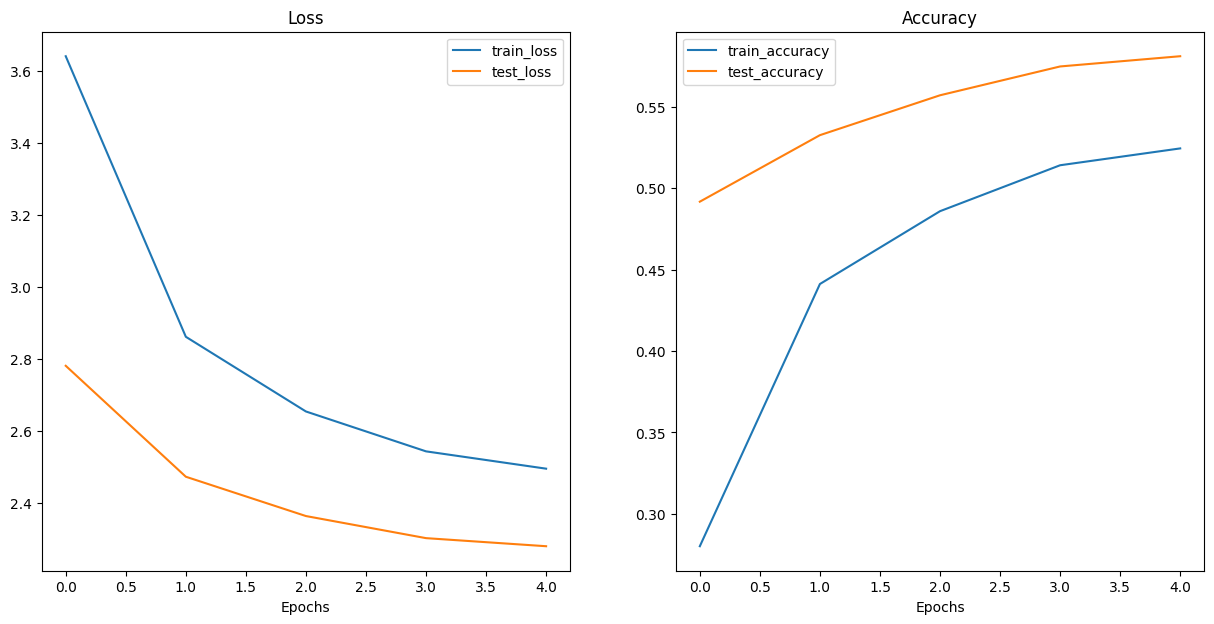

In [ ]:
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)

##10.7 Saving and loading FoodVision Big

In [ ]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth" 

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [ ]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

<All keys matched successfully>

##10.8 Checking FoodVision Big model size

Our FoodVision Big model is capable of classifying 101 classes versus FoodVision Mini's 3 classes, a 33.6x increase!

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


Hmm, it looks like the model size stayed largely the same (30 MB for FoodVision Big and 29 MB for FoodVision Mini) despite the large increase in the number of classes.

This is because all the extra parameters for FoodVision Big are only in the last layer (the classifier head).

All of the base layers are the same between FoodVision Big and FoodVision Mini.

# 11.Turning our FoodVision Big model into a deployable app

In [ ]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

## 11.1 Downloading an example image and moving it to the examples directory

In [6]:
# Download and move an example image
!wget /content/drive/MyDrive/Food_Vision/04-pizza-dad.jpeg 
# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

##11.2 Saving Food101 class names to file (class_names.txt)

Because there are so many classes in the Food101 dataset, instead of storing them as a list in our app.py file, let's saved them to a .txt file and read them in when necessary instead.

In [ ]:
# Check out the first 10 Food101 class names
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_names)) # leave a new line between each class

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [ ]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]
    
# View the first 5 class names loaded back in
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

## 11.3 Turning our FoodVision Big model into a Python script (model.py)

Just like the FoodVision Mini demo, let's create a script that's capable of instantiating an EffNetB2 feature extractor model along with its necessary transforms.

In [ ]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Writing demos/foodvision_big/model.py


##11.4 Turning our FoodVision Big Gradio app into a Python script (app.py)

In [ ]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]
    
### 2. Model and transforms preparation ###    

# Create model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface 
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing demos/foodvision_big/app.py


##11.5 Creating a requirements file for FoodVision Big (requirements.txt)

In [ ]:
%%writefile demos/foodvision_big/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4


Writing demos/foodvision_big/requirements.txt


##11.6 Downloading our FoodVision Big app files

In [ ]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 54%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpg (deflated 0%)
  adding: model.py (deflated 56%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##11.7 Deploying our FoodVision Big app to HuggingFace Spaces

In [ ]:
# IPython is a library to help work with Python iteractively 
from IPython.display import IFrame

# Embed FoodVision Big Gradio demo as an iFrame
IFrame(src="https://hf.space/embed/mrdbourke/foodvision_big/+", width=900, height=750)